In [81]:
import optuna
import joblib
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [82]:
#Load data
Data = pd.read_csv('car_price_dataset.csv')
print(Data.head())

        Brand   Model  Year  Engine_Size Fuel_Type    Transmission  Mileage  \
0         Kia     Rio  2020          4.2    Diesel          Manual   289944   
1   Chevrolet  Malibu  2012          2.0    Hybrid       Automatic     5356   
2    Mercedes     GLA  2020          4.2    Diesel       Automatic   231440   
3        Audi      Q5  2023          2.0  Electric          Manual   160971   
4  Volkswagen    Golf  2003          2.6    Hybrid  Semi-Automatic   286618   

   Doors  Owner_Count  Price  
0      3            5   8501  
1      2            3  12092  
2      4            2  11171  
3      2            1  11780  
4      3            3   2867  


In [83]:

# Check for NULL values in the dataset
null_values = Data.isnull().sum()

# Print columns with NULL values
print("Columns with NULL values:")
print(null_values[null_values > 0])

Columns with NULL values:
Series([], dtype: int64)


In [84]:
# Data preprocessing
numeric_columns = Data.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
Data[numeric_columns] = scaler.fit_transform(Data[numeric_columns])
Data = pd.get_dummies(Data, drop_first=True)

# Ensure all data is numeric and handle missing values
Data = Data.apply(pd.to_numeric, errors='coerce')
Data = Data.fillna(0)  # Fill missing values with 0 or use another strategy

# Convert boolean columns to integers
bool_columns = Data.select_dtypes(include=['bool']).columns
Data[bool_columns] = Data[bool_columns].astype(int)

# Define target and features
target = 'Price'
features = Data.drop(columns=[target]).columns

# Normalize the target variable
Data[target] = Data[target].astype(float)

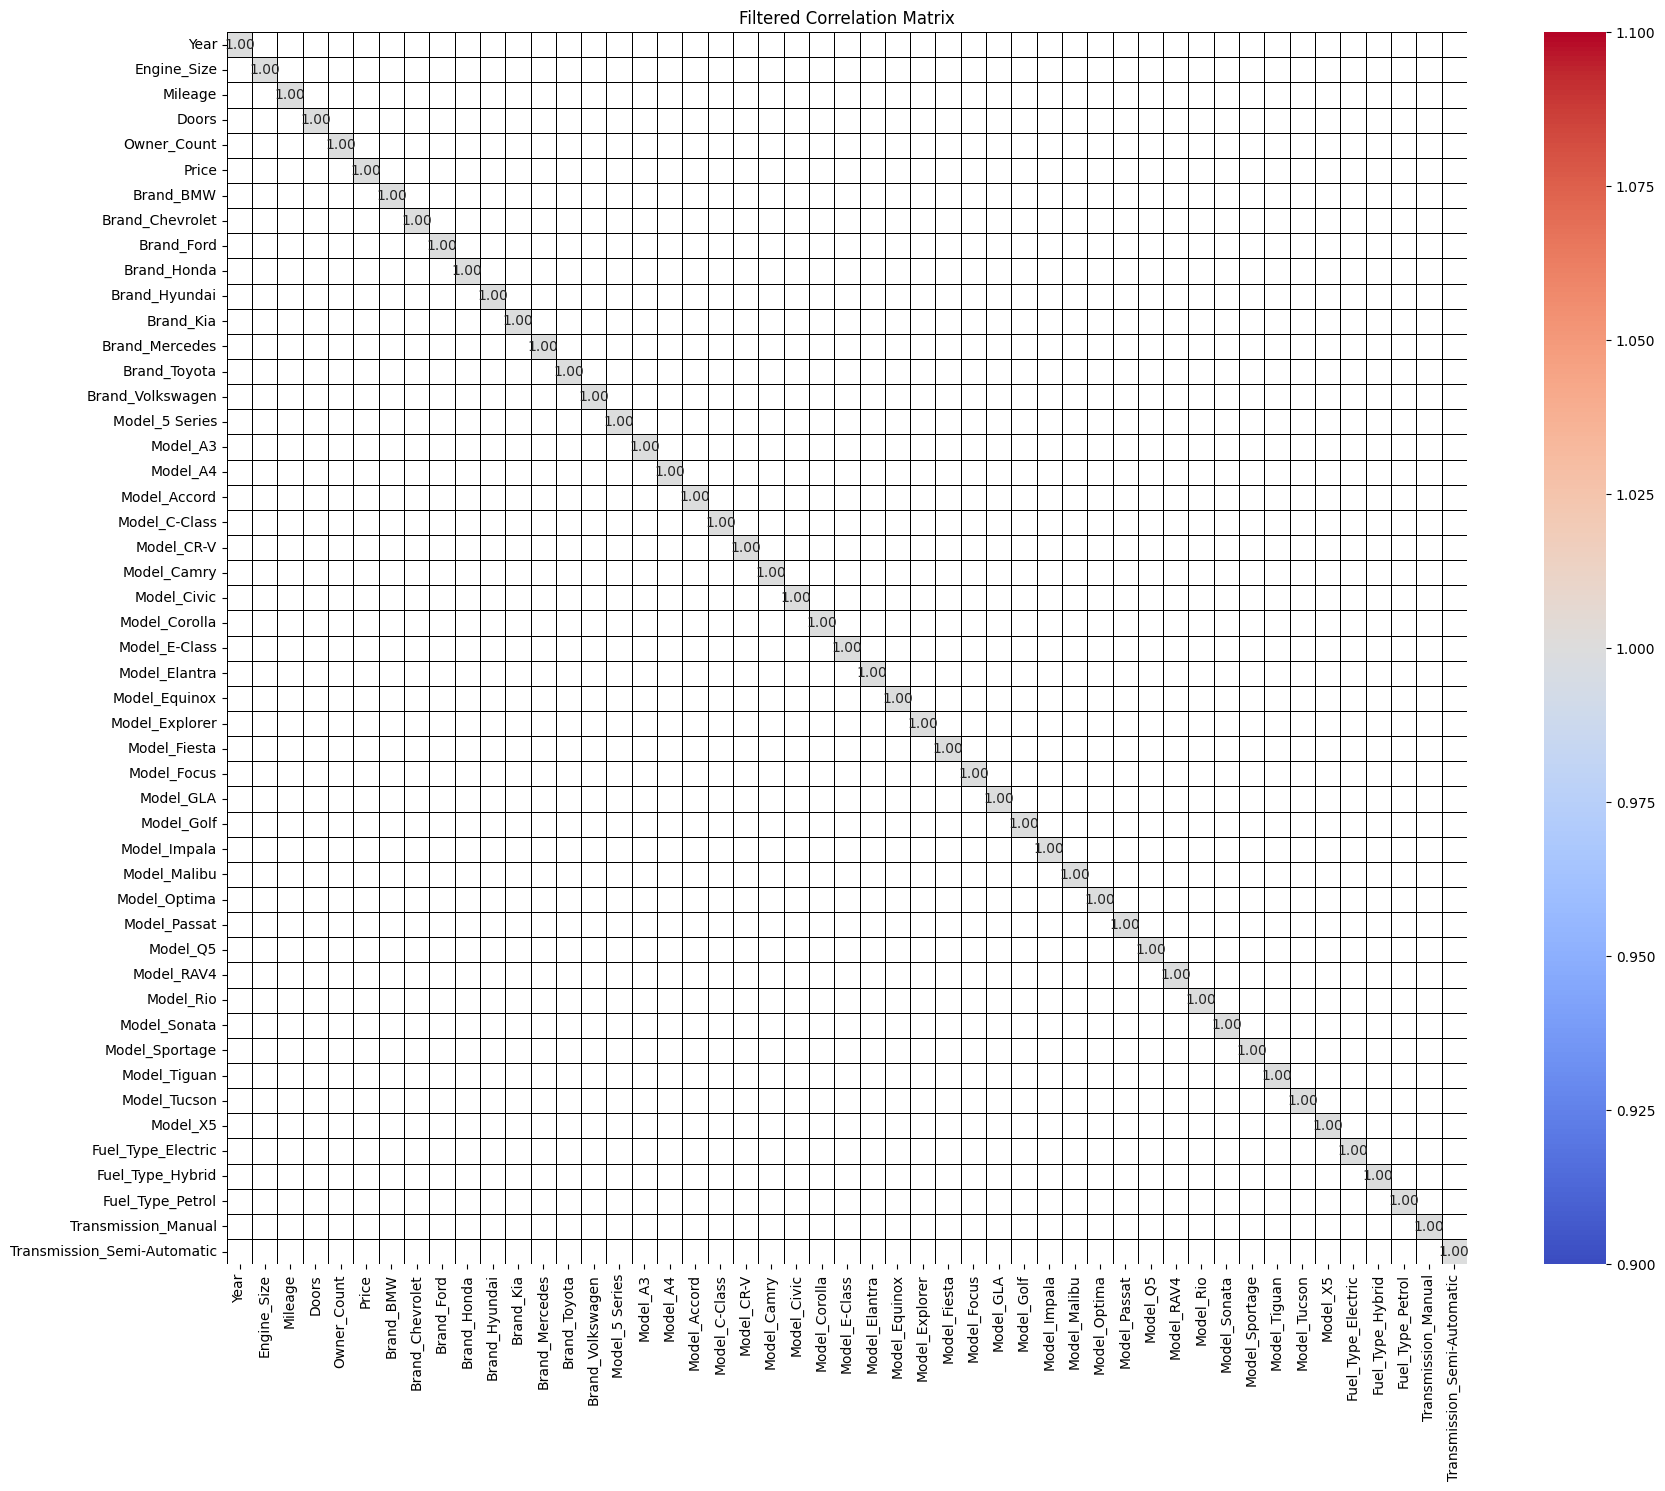

In [85]:
# Compute the correlation matrix
correlation_matrix = Data.corr()

# Set a threshold for significant correlations
threshold = 0.7

# Filter the correlation matrix
filtered_corr_matrix = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]

# Plot the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black')
plt.title('Filtered Correlation Matrix')
plt.show()

In [86]:
# Identify highly correlated features
high_corr_pairs = [(col1, col2) for col1 in filtered_corr_matrix.columns for col2 in filtered_corr_matrix.columns if col1 != col2 and abs(filtered_corr_matrix.loc[col1, col2]) > threshold]

# Print highly correlated pairs
print("Highly correlated pairs:")
for pair in high_corr_pairs:
    print(pair, filtered_corr_matrix.loc[pair[0], pair[1]])

# Remove one feature from each highly correlated pair
features_to_remove = set()
for col1, col2 in high_corr_pairs:
    # Example: Remove the second feature in each pair
    features_to_remove.add(col2)

# Drop the selected features from the dataset
Data_reduced = Data.drop(columns=features_to_remove)

Highly correlated pairs:


In [87]:
# Define target and features
X = Data[features]
y = Data[target]

# Initialize and train the model
model = RandomForestRegressor(random_state=42)  # Changed to RandomForestRegressor
model.fit(X, y)

# Compute permutation importance
perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
perm_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print(perm_importance_df.sort_values(by='Importance', ascending=False))

                        Feature  Importance
0                          Year    0.877825
2                       Mileage    0.620185
1                   Engine_Size    0.270012
43           Fuel_Type_Electric    0.138265
46          Transmission_Manual    0.026484
47  Transmission_Semi-Automatic    0.026212
44             Fuel_Type_Hybrid    0.022872
4                   Owner_Count    0.001207
3                         Doors    0.001007
45             Fuel_Type_Petrol    0.000371
5                     Brand_BMW    0.000188
6               Brand_Chevrolet    0.000164
8                   Brand_Honda    0.000153
13             Brand_Volkswagen    0.000152
12                 Brand_Toyota    0.000152
7                    Brand_Ford    0.000152
9                 Brand_Hyundai    0.000141
11               Brand_Mercedes    0.000136
10                    Brand_Kia    0.000133
15                     Model_A3    0.000130
16                     Model_A4    0.000106
35                     Model_Q5 

In [88]:
# Drop columns where importance is below specific value
low_importance_features = perm_importance_df[perm_importance_df['Importance'] < 0.02]['Feature']
Data = Data.drop(columns=low_importance_features)

# Update features after dropping low-importance columns
features = Data.drop(columns=[target]).columns

# Show the updated list of features
print("Updated list of features:")
print(Data.columns)

X = Data[features]
y = Data[target]

Updated list of features:
Index(['Year', 'Engine_Size', 'Mileage', 'Price', 'Fuel_Type_Electric',
       'Fuel_Type_Hybrid', 'Transmission_Manual',
       'Transmission_Semi-Automatic'],
      dtype='object')


In [89]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }
    model = XGBRegressor(**params, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return mean_squared_error(y_val, preds)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f'Best parameters: {study.best_params}')

[I 2025-03-14 12:32:44,522] A new study created in memory with name: no-name-79b0ad6e-4e27-4085-a061-43cfcb936a3a
[I 2025-03-14 12:32:45,211] Trial 0 finished with value: 0.0012129528677468514 and parameters: {'n_estimators': 438, 'learning_rate': 0.26551340932574463, 'max_depth': 4, 'subsample': 0.9874459655725765, 'colsample_bytree': 0.728952982709017}. Best is trial 0 with value: 0.0012129528677468514.
[I 2025-03-14 12:32:50,258] Trial 1 finished with value: 0.004509678361370708 and parameters: {'n_estimators': 724, 'learning_rate': 0.013523462783023936, 'max_depth': 9, 'subsample': 0.9007585495310454, 'colsample_bytree': 0.8883055667626942}. Best is trial 0 with value: 0.0012129528677468514.
[I 2025-03-14 12:32:52,426] Trial 2 finished with value: 0.009727999120600319 and parameters: {'n_estimators': 456, 'learning_rate': 0.27795013008012237, 'max_depth': 10, 'subsample': 0.8764826637529017, 'colsample_bytree': 0.8853247745899935}. Best is trial 0 with value: 0.0012129528677468514.

Best parameters: {'n_estimators': 809, 'learning_rate': 0.22270293103084315, 'max_depth': 4, 'subsample': 0.9361406884865591, 'colsample_bytree': 0.693407005811262}


In [90]:
# Use the best parameters from the Optuna study
best_params = study.best_params

# Initialize the XGBRegressor with the best parameters
model = XGBRegressor(**best_params, random_state=42)

# Train the model on the full training data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# Make predictions
preds = model.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, preds)
mae = mean_absolute_error(y_val, preds)

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')

MSE: 0.0006
MAE: 0.0177


In [ ]:
# Save both the scaler and the model in one file
joblib.dump({'model': model, 'scaler': scaler}, 'CarPricePredictionModel.pkl')

['RegressionModel.pkl']

In [ ]:
# Load both the scaler and the model from the file
data = joblib.load('CarPricePredictionModel.pkl')
loaded_model = data['model']
scaler = data['scaler']

print("Model and scaler loaded from 'model_and_scaler.pkl'")

Model and scaler loaded from 'model_and_scaler.pkl'


In [ ]:
# Example raw data (ensure it includes all original columns from the dataset, including the target variable 'Price')
raw_data = {
    'Price': 0, #Will be blank for prediction
    'Brand': 'Kia',
    'Model': 'Rio',
    'Year': 2020,
    'Engine_Size': 4.2,
    'Fuel_Type': 'Diesel',
    'Transmission': 'Manual',
    'Mileage': 289944,
    'Doors': 3,
    'Owner_Count': 5
}

# Convert raw data to a DataFrame
raw_data_df = pd.DataFrame([raw_data])  # Ensure it's a DataFrame with one row

# Preprocess the raw data
# 1. Scale numeric columns
numeric_columns = ['Year', 'Engine_Size', 'Mileage', 'Doors', 'Owner_Count', 'Price']  # Include 'Price' for consistency
raw_data_df[numeric_columns] = scaler.transform(raw_data_df[numeric_columns])

# 2. Manually create one-hot encoded columns for categorical features
# Define all possible one-hot encoded columns for Fuel_Type and Transmission
expected_categorical_columns = {
    'Fuel_Type_Electric': 0,
    'Fuel_Type_Hybrid': 0,
    'Transmission_Manual': 0,
    'Transmission_Semi-Automatic': 0
}

# Set the correct one-hot encoded values based on the raw input
if raw_data['Fuel_Type'] == 'Electric':
    expected_categorical_columns['Fuel_Type_Electric'] = 1
    expected_categorical_columns['Fuel_Type_Hybrid'] = 0
elif raw_data['Fuel_Type'] == 'Hybrid':
    expected_categorical_columns['Fuel_Type_Hybrid'] = 1
    expected_categorical_columns['Fuel_Type_Electric'] = 0
elif raw_data['Fuel_Type'] == 'Petrol':
    expected_categorical_columns['Fuel_Type_Hybrid'] = 0
    expected_categorical_columns['Fuel_Type_Electric'] = 0

if raw_data['Transmission'] == 'Manual':
    expected_categorical_columns['Transmission_Manual'] = 1
    expected_categorical_columns['Transmission_Semi-Automatic'] = 0
elif raw_data['Transmission'] == 'Semi-Automatic':
    expected_categorical_columns['Transmission_Semi-Automatic'] = 1
    expected_categorical_columns['Transmission_Manual'] = 0
elif raw_data['Transmission'] == 'Automatic':
    expected_categorical_columns['Transmission_Semi-Automatic'] = 0
    expected_categorical_columns['Transmission_Manual'] = 0


# Add the one-hot encoded columns to the DataFrame
for col, value in expected_categorical_columns.items():
    raw_data_df[col] = value

# 3. Drop the 'Price' column before prediction
raw_data_df = raw_data_df.drop(columns=['Price', 'Brand', 'Model', 'Fuel_Type', 'Transmission', 'Doors', 'Owner_Count'])  # Drop columns not used in the model

# 4. Align columns with the training data
# Ensure the raw data has the same columns as the training data
missing_cols = set(features) - set(raw_data_df.columns)
for col in missing_cols:
    raw_data_df[col] = 0  # Add missing columns with default value 0
raw_data_df = raw_data_df[features]  # Reorder columns to match the training data


# Make a prediction
scaled_prediction = loaded_model.predict(raw_data_df)

# Scale the predicted price back to its original scale
# Create a temporary DataFrame to use the scaler's inverse_transform
temp_df = pd.DataFrame([[0, 0, 0, 0, 0, scaled_prediction[0]]], columns=numeric_columns)
original_price = scaler.inverse_transform(temp_df)[0, -1]  # Get the original price

print(f'Predicted Price: {original_price}')

Predicted Price: 8470.043059566673
